# Invesco QR Trading Test Question 2

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import cvxpy as cvx
import pandas as pd
import numpy as np
import fix_yahoo_finance as yf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor    

import seaborn as sns
sns.reset_orig()

%matplotlib inline
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.height', 12)
pd.set_option('display.max_rows', 12)

height has been deprecated.



**(Please update PATH accordinly before running.)**

In [2]:
PATH = u'/Users/Norman/Documents/GitHub/Invesco/Q2/'

In [3]:
## read intermediate output from pickled files if True, skipping intermediate calculations
## run and pickle intermediate output to PATH if False

read_from_exiting_output = True

## 0. Executive Summary

My stock of interest is Nvidia. I plan to investigate its daily returns. The time spans from 2015-04-30 to 2018-04-30.

I modeled the daily return of Nvidia as a combination of systematic return and idiosyncratic return. The systematic piece consists of a two-stage multi-factor regression and a low-rank approximation for latent factors using Robust PCA. From the two stage framework, it is observed that *Market* together with *Value*, *Momentum* and *Industry (technology)* factors can explain part of systematic variation of the returns. For Robust PCA, however, due to its limitations the low rank matrix cannot be retrieved. 

The idiosyncratic component can be captured by the sparse matrix from the output of Robust PCA. I showed that the timing of large isolated shocks can be captured by its earning surprises. 

In sum, the model consists of a two-stage multifactor framework used to explain daily returns with addtion of historical earning surprise for quarter end shocks.

## 1. Methodology overview

The systematic piece will be largely extracted using multi-factor models. The factor pool contains

* Market: a factor with a long history, a standard component in almost every factor models

* Industry (technology): industry are a pooled from companies with similar corporate structure and business foundations; it can capture  variations that are unique among industry peers

* Quality: a somewhat controversial factor, because there is no consensus in the academia nor practitioners that it is a real risk factor. However, stocks in this risk factor have good cash flow valuation, quality in their accounting reports; it is widely used in pratice

* Value: a factor popularized by Fama-French, where the risk premium is earned by holding value stocks. This factor is easy to understand, have been proved empirically before and after academic publications

* Size: a Fama-French factor, where the risk premium is earned by holding low caps. Although past research has found that the factor almost disappears after publication, it could be used as an easy proxy for liquidity.

* Momentum: one of the well investigated factor, where the risk premium is paid to investors for bearing a large crash risk (negative skewness). 

* Minimum Volatility: a popular factor that captures the low risk anomaly in the market by by holding defensive stocks; it tend to outperform during market downturns

A series of linear regression will be performed to retrieve the systematic returns. The raw return of target stock will be first regressed against *Market* returns. Its residuals is then regressed against a collection of *Style* factors and *Industry* return. Then the systematic piece will process further to retieve low rank approximation of latent factors.

The low rank approximation is carried out using Robust PCA. In particular, the above two-stage regression is performed for all $n$ stocks within the tech sector to get the residual time series which spans $t$-horizon, i.e. a t-by-n matrix of two stage residuals. The Robust PCA is then applied to the t-by-n matrix to (hopefully) obtain a low rank approximation of latent factors (t-by-n) and a sparse matrix (t-by-n) containing all idiosyncratic returns/shocks of $n$ stocks.

## 2. Data Preparation

### 2.1 Data import

Source:
* Market and style factors (using iShare ETFs as proxies): Yahoo Finance
* Industry returns: Fama-French data library
* Tech tickers: Wikipedia
* Nvidia earning surprises: Zacks.com

In [4]:
yf.pdr_override()

start_date = '2015-04-30'
end_date = '2018-04-30' # 2018-01-01
all_tech_tickers = list(pd.read_csv(PATH + 'tech_tickers.csv')['Ticker symbol'].values)
ticker_subset = ['AAPL','GOOGL','MSFT','FB','ORCL','INTC','CSCO'
                 ,'IBM','TXN','AVGO','NVDA','ADBE','CRM','ADP','QCOM']
factor_etf = ['QUAL','IVE','USMV','MTUM','SIZE','^GSPC']

In [5]:
# data download
if not read_from_exiting_output:
    ticker_data = yf.download(all_tech_tickers,start_date,end_date,as_panel=True)
    factor_data = yf.download(factor_etf,start_date,end_date,as_panel=True)

In [6]:
if read_from_exiting_output:
    ticker_data = pd.read_pickle(PATH+'ticker_data')
    factor_data = pd.read_pickle(PATH+'factor_data')
else:
    pd.to_pickle(ticker_data, PATH+'ticker_data')
    pd.to_pickle(factor_data, PATH+'factor_data')

In [7]:
## industry return from fama french website, taking the average industry returns

## Only Technology return is used

headers = pd.read_csv(PATH+'10_Industry_Portfolios_Daily.CSV',
                      skiprows=9,header=0,index_col=0,nrows=0)
ind_ret = pd.read_csv(PATH+'10_Industry_Portfolios_Daily.CSV',
                      skiprows=24235,header=0,index_col=0,
                      parse_dates=True,skip_footer=1)
ind_ret.columns = headers.columns

ind_ret = ind_ret[start_date:end_date] 
ind_ret = ind_ret[1:]/100 # matching time horizon

/Users/Norman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The 'skip_footer' argument has been deprecated and will be removed in a future version. Please use the 'skipfooter' argument instead.
  if __name__ == '__main__':
/Users/Norman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [8]:
## Calculating daily log returns
adj_cls_ticker = ticker_data['Adj Close']
adj_cls_factor = factor_data['Adj Close']

daily_log_ret_ticker = adj_cls_ticker.apply(np.log).diff()
daily_log_ret_factor = adj_cls_factor.apply(np.log).diff()
daily_log_ret_factor.columns = ['Value','Momentum','Quality','Size','Min Vol','Market']

### 2.2. Data cleaning

Functions below corrects missing values in the times series, print out dataframe summary stats and winsorize the data if necessary.

In [9]:
def preprocessing(df):
    """
    Remove columns whose entries are all nans or zeros; fill the remaining nans with zeros

    Returns a processed dataframe
    """
    
    df = df.dropna(axis=1,how='all') # drop columns with only nans
    df = df.loc[:, (df != 0).any(axis=0)] # drop columns with only zeros
    df = df.dropna(axis=0,how='all') # drop rows with only nans
    df = df.loc[(df != 0).any(axis=1),:] # drop rows with only zeros
    df = df.fillna(0.0)
    
    return df

def data_validation(df, outlier_thres = 3, is_return = True):
    """
    Print dataframe summary and print outliers summary if df is asset return
        
    """
    
    print 'DataFrame shape:',df.shape
#     print 'DataFrame unique datatypes:', df.dtypes.unique()
    print 'Number of NaNs: %d' % df.isnull().values.sum()
    print 'Number of Infs: %d' % np.sum(np.isinf(df.values))
    
    df_summary = df.describe(percentiles=[0.01,0.99]).T
    print '\nDataFrame summary:'
    print df_summary

    if is_return:
        print '\nOutliers:'
        outlier = df_summary.loc[(df_summary['max']>outlier_thres) | 
                                 (df_summary['min']<-outlier_thres),:]
        print outlier
        
    return

def winsorize_series(series, multiple = 3):
    """
    Trim data series to multiple standard deviation away from mean
    
    Returns a winsorized series
    """
    
    lo = series.mean() - multiple*series.std()
    hi = series.mean() + multiple*series.std()
    series[series>hi]=hi
    series[series<lo]=lo
    
    return series

def winsorize_df(df):
    """
    Wrapper to trim dataframe by column
    
    Returns a trimmed dataframe    
    """
    return df.apply(winsorize_series, axis=1)

In [10]:
## preprocessing, removing NaN and zeros where appropriate

daily_log_ret_ticker = preprocessing(daily_log_ret_ticker)
daily_log_ret_factor = preprocessing(daily_log_ret_factor)
ind_ret = preprocessing(ind_ret)

In [11]:
## visualization, looking for bad data and outliers

data_validation(daily_log_ret_ticker)

DataFrame shape: (755, 74)
Number of NaNs: 0
Number of Infs: 0

DataFrame summary:
      count      mean       std       min        1%       50%       99%       max
AAPL  755.0  0.000441  0.014468 -0.067965 -0.042427  0.000378  0.040638  0.062940
ACN   755.0  0.000727  0.012171 -0.075614 -0.038629  0.001324  0.030651  0.059848
ADBE  755.0  0.001416  0.015429 -0.086548 -0.047252  0.001382  0.037239  0.115486
ADI   755.0  0.000557  0.016322 -0.081328 -0.044230  0.000616  0.044937  0.084466
ADP   755.0  0.000535  0.012291 -0.064532 -0.036640  0.000687  0.026662  0.087145
ADS   755.0 -0.000487  0.018534 -0.215273 -0.047892  0.000857  0.038852  0.079761
...     ...       ...       ...       ...       ...       ...       ...       ...
V     755.0  0.000896  0.012602 -0.054137 -0.038485  0.001681  0.030954  0.071787
VRSN  755.0  0.000814  0.013469 -0.074061 -0.036245  0.001252  0.034998  0.063264
WDC   755.0 -0.000149  0.025048 -0.125916 -0.075107  0.000507  0.052596  0.142781
WU    755.0  0.

In [12]:
data_validation(daily_log_ret_factor)

DataFrame shape: (755, 6)
Number of NaNs: 0
Number of Infs: 0

DataFrame summary:
          count      mean       std       min        1%       50%       99%       max
Value     755.0  0.000302  0.008334 -0.042455 -0.023610  0.000341  0.021410  0.035490
Momentum  755.0  0.000612  0.009029 -0.043722 -0.030835  0.001078  0.022280  0.038913
Quality   755.0  0.000397  0.008155 -0.038999 -0.024152  0.000504  0.021129  0.044981
Size      755.0  0.000369  0.018663 -0.325446 -0.025815  0.000259  0.020005  0.331955
Min Vol   755.0  0.000397  0.006772 -0.038240 -0.018255  0.000681  0.016780  0.029876
Market    755.0  0.000316  0.008317 -0.041843 -0.025376  0.000373  0.020190  0.038291

Outliers:
Empty DataFrame
Columns: [count, mean, std, min, 1%, 50%, 99%, max]
Index: []


In [13]:
data_validation(daily_log_ret_factor)

DataFrame shape: (755, 6)
Number of NaNs: 0
Number of Infs: 0

DataFrame summary:
          count      mean       std       min        1%       50%       99%       max
Value     755.0  0.000302  0.008334 -0.042455 -0.023610  0.000341  0.021410  0.035490
Momentum  755.0  0.000612  0.009029 -0.043722 -0.030835  0.001078  0.022280  0.038913
Quality   755.0  0.000397  0.008155 -0.038999 -0.024152  0.000504  0.021129  0.044981
Size      755.0  0.000369  0.018663 -0.325446 -0.025815  0.000259  0.020005  0.331955
Min Vol   755.0  0.000397  0.006772 -0.038240 -0.018255  0.000681  0.016780  0.029876
Market    755.0  0.000316  0.008317 -0.041843 -0.025376  0.000373  0.020190  0.038291

Outliers:
Empty DataFrame
Columns: [count, mean, std, min, 1%, 50%, 99%, max]
Index: []


**Comment:** All data is cleaned and there doesn't seem to be any outlier that stands out. Proceed futher with model implementation

## 3. Model Implementation

### 3.1 Multi-factor regression

The sector below contains functions and routines to perform linear regression. It contains functions to check for stationarity and to calcualte VIF of exogenous variables. It also contains a wrapper function to perform linear regression, with options to print regression summary statistics and residual plots.

In [14]:
def stationarity_test(data_series, critical_level = 0.05, print_result=False): 
    """
    Test if data is stationary using Augmented Dickey Fuller
    """
    if isinstance(data_series, pd.Series) or isinstance(data_series, pd.DataFrame):
        data_series = data_series.values
        
    result = adfuller(data_series)
    adf_stat, p_value = result[0], result[1]
        
    if p_value > 0.05:
        raise ValueError('Cannot reject the null hypothesis at %.2 level that the series is stationary')
        
    if print_result:
        print('ADF Statistic: %f' % adf_stat) 
        print('p-value: %f' % p_value)

def calculate_vif(X):
    """
    Calculate VIF stats of given exogenous variable X (multi-dimensional)
    
    Returns series of VIF stats by indexed by variable name
    """
    
    vif = [variance_inflation_factor(X.values, ix) for ix in range(X.shape[1])]
    
    if isinstance(X, pd.DataFrame):
        vif = pd.Series(vif,index=X.columns)

    return vif

def lin_reg(Y,X, add_cos = True, print_plots=True, print_summary=True):
    """
    Performs linear regression, print summary stats and residual plots
    
    Returns regression result object
    """
    
    # dimension check
    assert(len(Y) == len(X))
    
    # add constants to X if necessary
    if add_cos:X = sm.add_constant(X)
    
    # run OLS and print results
    model = sm.OLS(Y,X,hasconst=True)
    res = model.fit(cov_type='HC0') # HC0 'HAC',cov_kwds={'maxlags':1}
    
    if print_summary: print(res.summary())
        
    if print_plots:
        # remove constants for Seaborn plotting
        if add_cos:X=X.iloc[:,1:]

        # set up figure
        fig, ax = plt.subplots(2,2,figsize=(12,12))

        combined_X = (res.params*X).dropna(axis=1).sum(axis=1)

        # Y vs combined X
        sns.regplot(combined_X,Y,ax = ax[0,0])
        ax[0,0].set_xlabel('Combined X')
        ax[0,0].set_ylabel('Y')
        ax[0,0].set_title('Regression Plot')

        # residual scatter plot
        ax[0,1].scatter(range(len(res.resid)), res.resid)
        ax[0,1].set_title('Regression Residuals')

        # residual acf
        plot_acf(res.resid,ax=ax[1,0],lags=15)
        ax[1,0].set_title('Residual ACF')

        # residual pacf
        plot_pacf(res.resid,ax=ax[1,1],lags=15)
        ax[1,1].set_title('Residual PACF')
        ax[1,1].set_ylim([-1.15,1.15])
    
    return res

In [15]:
## stationarity check
combined_ts_series = pd.concat([daily_log_ret_ticker,daily_log_ret_factor,ind_ret],axis=1)
for col in combined_ts_series:
    stationarity_test(combined_ts_series[col])

**Comment:** The routine above didn't raise any error, meaning the all the input data is stationary.

In [16]:
## multicollinearity check
all_factor = pd.concat([daily_log_ret_factor, ind_ret['HiTec']],axis=1)
calculate_vif(all_factor)

Value       28.591642
Momentum    11.676978
Quality     30.996701
Size         1.169329
Min Vol      8.733257
Market      94.864967
HiTec        3.496056
dtype: float64

**Comment:** From the VIF test, it is clear that there exists collinearity, especially the *Market* factor. This might be because all the style factors are proxied by ETFs. So I decided to first perform a standard CAPM regression. Its residual will be used as endogenous variable against *Style* factor and *Industry* returns in the second stage regression.

#### 3.1.1 CAPM

In [17]:
stock_of_interest = 'NVDA'
single_stock_ret = daily_log_ret_ticker[stock_of_interest]

                            OLS Regression Results                            
Dep. Variable:                   NVDA   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 20 Jun 2018   Prob (F-statistic):                nan
Time:                        23:56:09   Log-Likelihood:                 1774.8
No. Observations:                 755   AIC:                            -3546.
Df Residuals:                     753   BIC:                            -3536.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.142      0.0

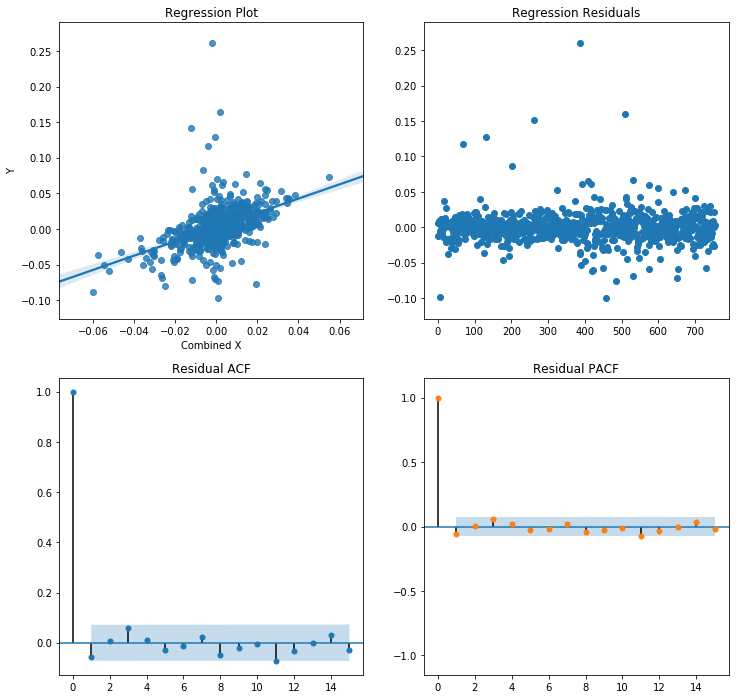

In [18]:
## CAPM
mkt_ret = daily_log_ret_factor['Market'].to_frame()

single_capm_res = lin_reg(Y=single_stock_ret, X=mkt_ret, 
                          print_plots=True, print_summary=True)

**Comment:** not surprisingly, both intercept and beta coefficient from CAPM are significant. The residual does exhibit some heteroskedaticity, which is normal for financial time series. There's little serial correlation in residuals, however, which is a good sign.

CAPM only explains around 21% of the variation - not powerful, but it's a good start. 

#### 3.1.2 Style and industry regression

In [19]:
style_factor = ['Quality','Value','Min Vol','Momentum','Size']
style_ind = pd.concat([daily_log_ret_factor[style_factor], 
                       ind_ret['HiTec']],axis=1).dropna()
calculate_vif(style_ind)

Quality     20.622637
Value       11.161686
Min Vol      8.732857
Momentum     7.244371
Size         1.168528
HiTec        3.135872
dtype: float64

**Comment**: VIF output shows that there is collinearity in *Quality*. As is known, *Quality* emphasizes firm's profitability and earning sustainability. It partially resembles characteristics of *Value* because a comprehensive measure of *Value* incorporates firm's earning potential as well. As the same time, *Quality* can be defensive because it assembles stocks with steady earnings under market downturns. In this regard, it correlates with *Min Vol*. So I decide to exclude *Quality* from the regression and proceed with the rest as exogenous variable.

In [20]:
style_ind_ex_qual = style_ind[style_ind.columns[style_ind.columns!='Quality']]
calculate_vif(style_ind_ex_qual)

Value       6.010819
Min Vol     7.712888
Momentum    5.974256
Size        1.168385
HiTec       3.063619
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 20 Jun 2018   Prob (F-statistic):                nan
Time:                        23:56:10   Log-Likelihood:                 1845.4
No. Observations:                 755   AIC:                            -3679.
Df Residuals:                     749   BIC:                            -3651.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.803      0.4

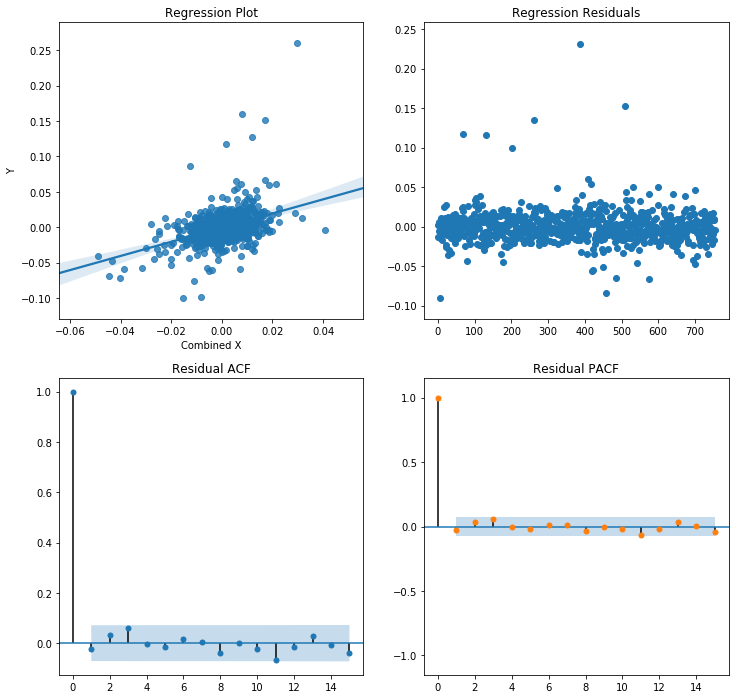

In [21]:
## style + industry
single_style_ind_res = lin_reg(Y=single_capm_res.resid, 
                                X=style_ind_ex_qual, 
                                print_plots=True, 
                                print_summary=True)

**Comment:** the Style-industry regression is able to squeeze out around 17% of variations from the residuals. The intercept is insignificant from zero, as it is mostly stripped out in the first stage regression. Regarding the beta coefficients, *Min Vol* and *Size* are insignificant. This is expected as *Size* proxied by ETF contains only long postions in small cap names and Nvidia is a large cap stock. Meanwhile, Nvidia is often classfied as growth stock, quite in opposite of denfensive stocks that characterize *Min Vol*.

The rest of style factors all exhibits significant coefficients. This can be largely explained by Nvidia being a growth stock from tech sector because 
1. Growth stocks exhibits momentum
2. Value and Growth are (almost) two sides of a coin

The plot below shows the residual time series from the style-industry regression. There is still some variations in the return series and most noticebly, the spikes from time to time. To further separate returns into systematic vs idiosyncratic, a Robust PCA is performed to decompose residuals into a latent, low-rank component  $Z$  and a sparse "shocks" component $S$.

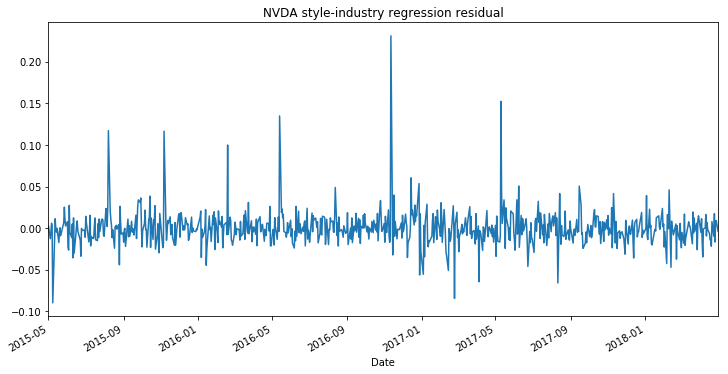

In [22]:
single_style_ind_res.resid.plot(title='NVDA style-industry regression residual',
                                figsize=(12,6))

### 3.2 Robust PCA

The Robust PCA can be formulated as follow:

$$\min_{Z, S} \|Z\|_* + \lambda\|S\|_1 \text{ subject to } A = Z + S$$
, where $\|.\|_*$ is the nuclear norm (i.e. the sum of the singular values) approximating the rank. 

The application here is to decompose a matrix $A$ containing $t$ period returns for $n$ securities into a latent, low-rank component $Z$ which can be thought of as latent factors that explain returns, and a sparse component $S$ which is a idiosyncratic piece. 

In our case, $A$ is an t-by-n matrix of t-horizon residuals time-series of all $n$ tech stocks obtained from the above two stage regressions. In an idea case, the resulted $Z$ will have a $\mathbf{rank}(Z) << n$, representing $\mathbf{rank}(Z)$ latent factors. $S$ will be sparse, representing the idiosyncratic component.

A selected list of $\lambda$ will be used for tuning. Each $\lambda$ corresponds to one set of $Z$ and $S$. 

#### 3.2.1 Robust PCA routines

In [23]:
# CAPM regression for all tech stocks
capm_result = {}
capm_resid = {}

for ticker in all_tech_tickers:
    capm_result[ticker] = lin_reg(Y=daily_log_ret_ticker[ticker], 
                                  X=mkt_ret, 
                                  print_plots=False, 
                                  print_summary=False)
    capm_resid[ticker] = capm_result[ticker].resid
    
capm_resid_df = pd.DataFrame.from_dict(capm_resid)

In [24]:
# style factor regression for all tech stocks
style_result = {}
style_resid = {}

for ticker in all_tech_tickers:
    style_result[ticker] = lin_reg(Y=capm_resid_df[ticker], 
                                   X=style_ind_ex_qual,
                                   print_plots=False, 
                                   print_summary=False)
    style_resid[ticker] = style_result[ticker].resid
    
style_resid_df = pd.DataFrame.from_dict(style_resid)

In [25]:
def robustPCA(A, lamb):
    """
    Performs robust PCA on a real n x p matrix A.
    The argument lamb > 0 represents penalty on l_1 norm.
    
    Returns low-rank matrix and sparse matrix
    """

    S = cvx.Variable(*A.shape)
    
    objective = cvx.Minimize(cvx.norm(A - S, "nuc") + lamb*cvx.norm(S, 1))
    prob = cvx.Problem(objective)
    prob.solve()
    
    Z = A - S.value
    
    return Z, S.value

def approxRank(Z):
    """
    Count number of sv > 1e-6*sigma_max for rank approximation.
    
    Returns an int of approximated rank
    """
    
    sv = np.linalg.svd(Z.values, compute_uv=False)
    
    return (sv > 1e-4*max(sv)).sum()

In [26]:
## Training
lamb_list = [0.1, 0.05, 0.01,0.005]

if not read_from_exiting_output:
    Z_output={}
    S_output={}

    for lamb in lamb_list:
        Z, S = robustPCA(style_resid_df.as_matrix(), lamb)
        Z_output[lamb]=pd.DataFrame(Z,index=style_resid_df.index,columns=style_resid_df.columns)
        S_output[lamb]=pd.DataFrame(S,index=style_resid_df.index,columns=style_resid_df.columns)

In [27]:
## pickle trained file to local
if not read_from_exiting_output:
    pd.to_pickle(Z_output, PATH+'Z_output')
    pd.to_pickle(S_output, PATH+'S_output')
else:
## read trained pickle file from local
    Z_output = pd.read_pickle(PATH+'Z_output')
    S_output = pd.read_pickle(PATH+'S_output')

#### 3.2.2 Robust PCA results for selected companies

Sectors below show the results of Robust PCA for a subset of all tech companies. First is sets of charts, one set for each $\lambda$. The charts include:
1. Raw returns of selected companies as a line chart (top), 
2. Low-rank approximation of selected companies as a line chart (middle), and 
3. Sparse component of the selected companies as a bar chart (bottom)

In an idea scenario, $\mathbf{rank}(Z)<<n$, and $S$ being sparse.




Set of charts for lambda = 0.100


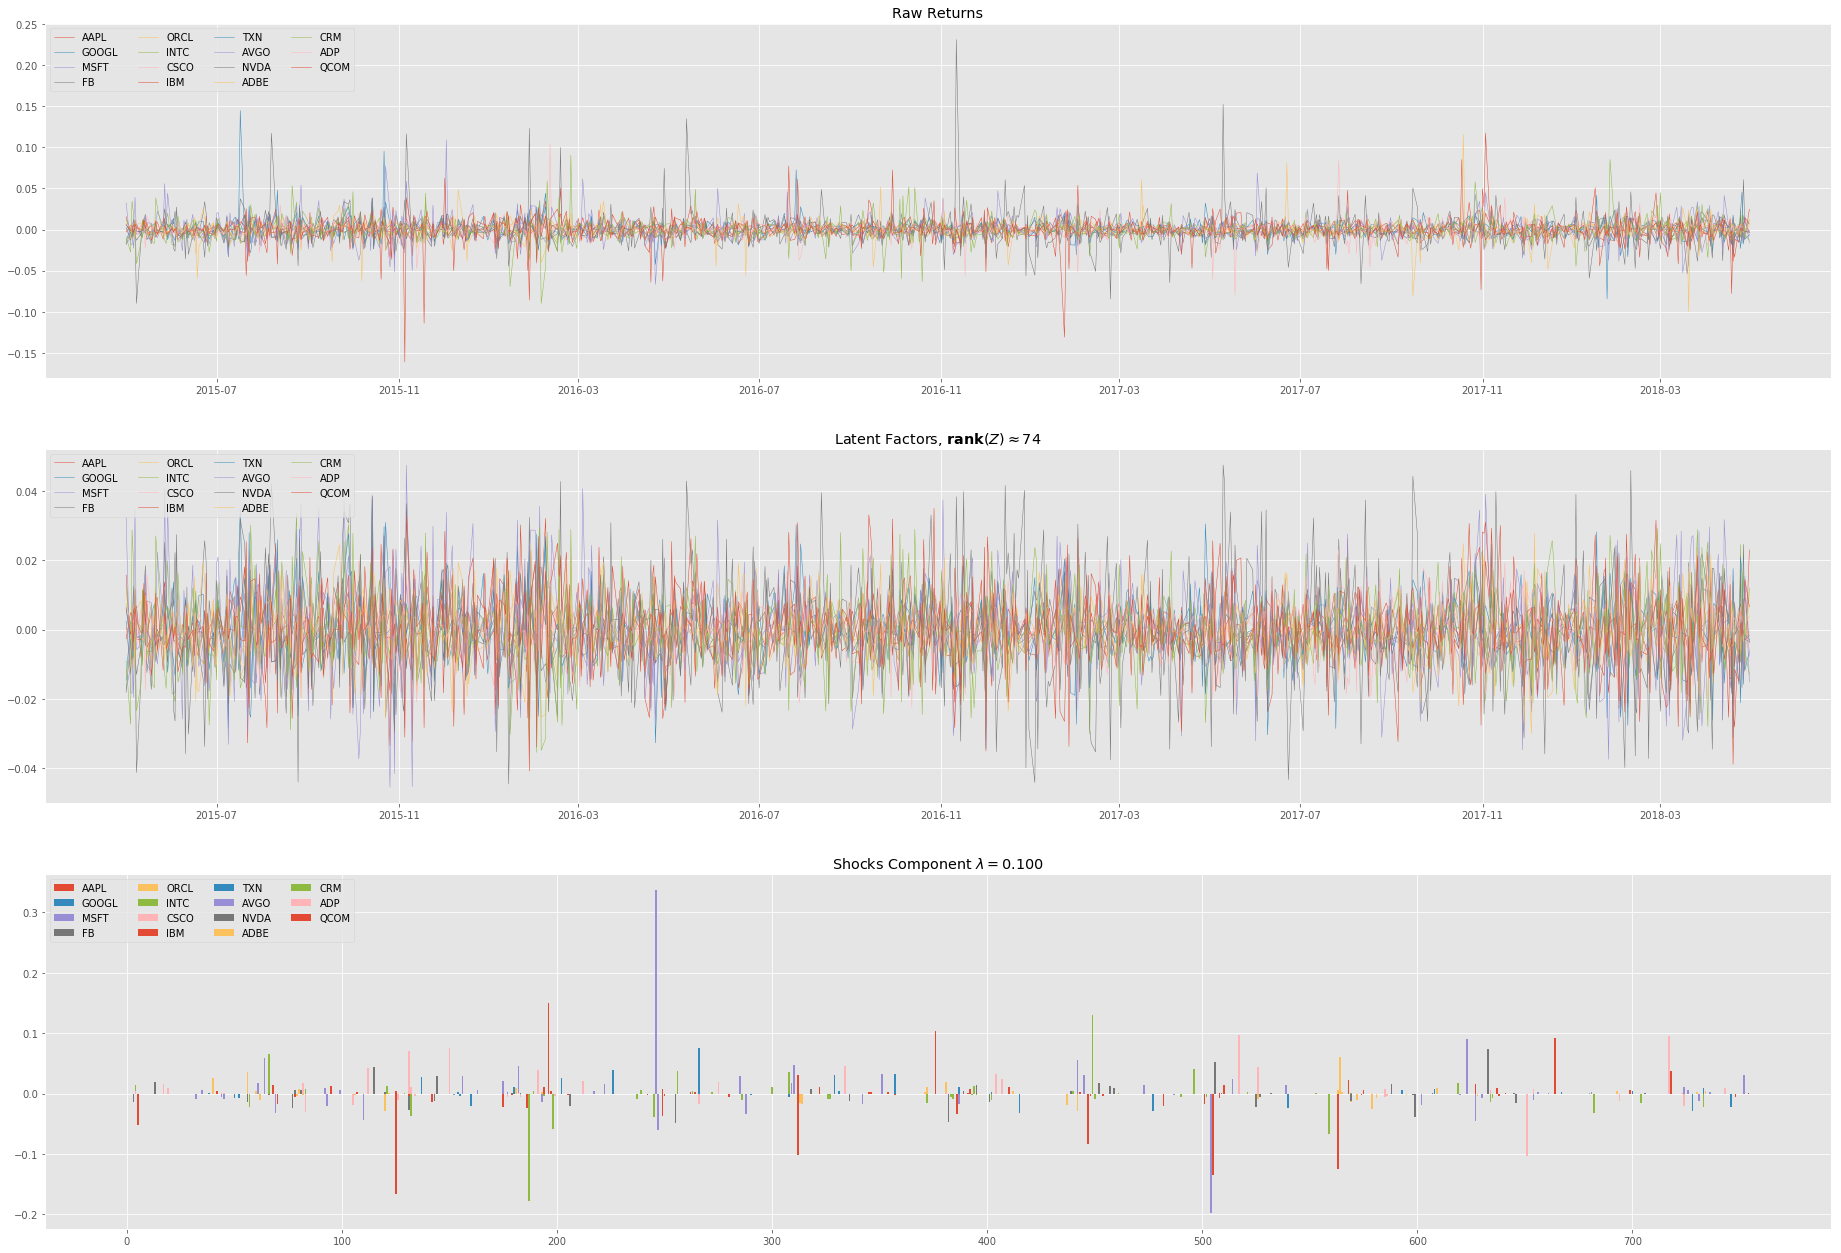




Set of charts for lambda = 0.050


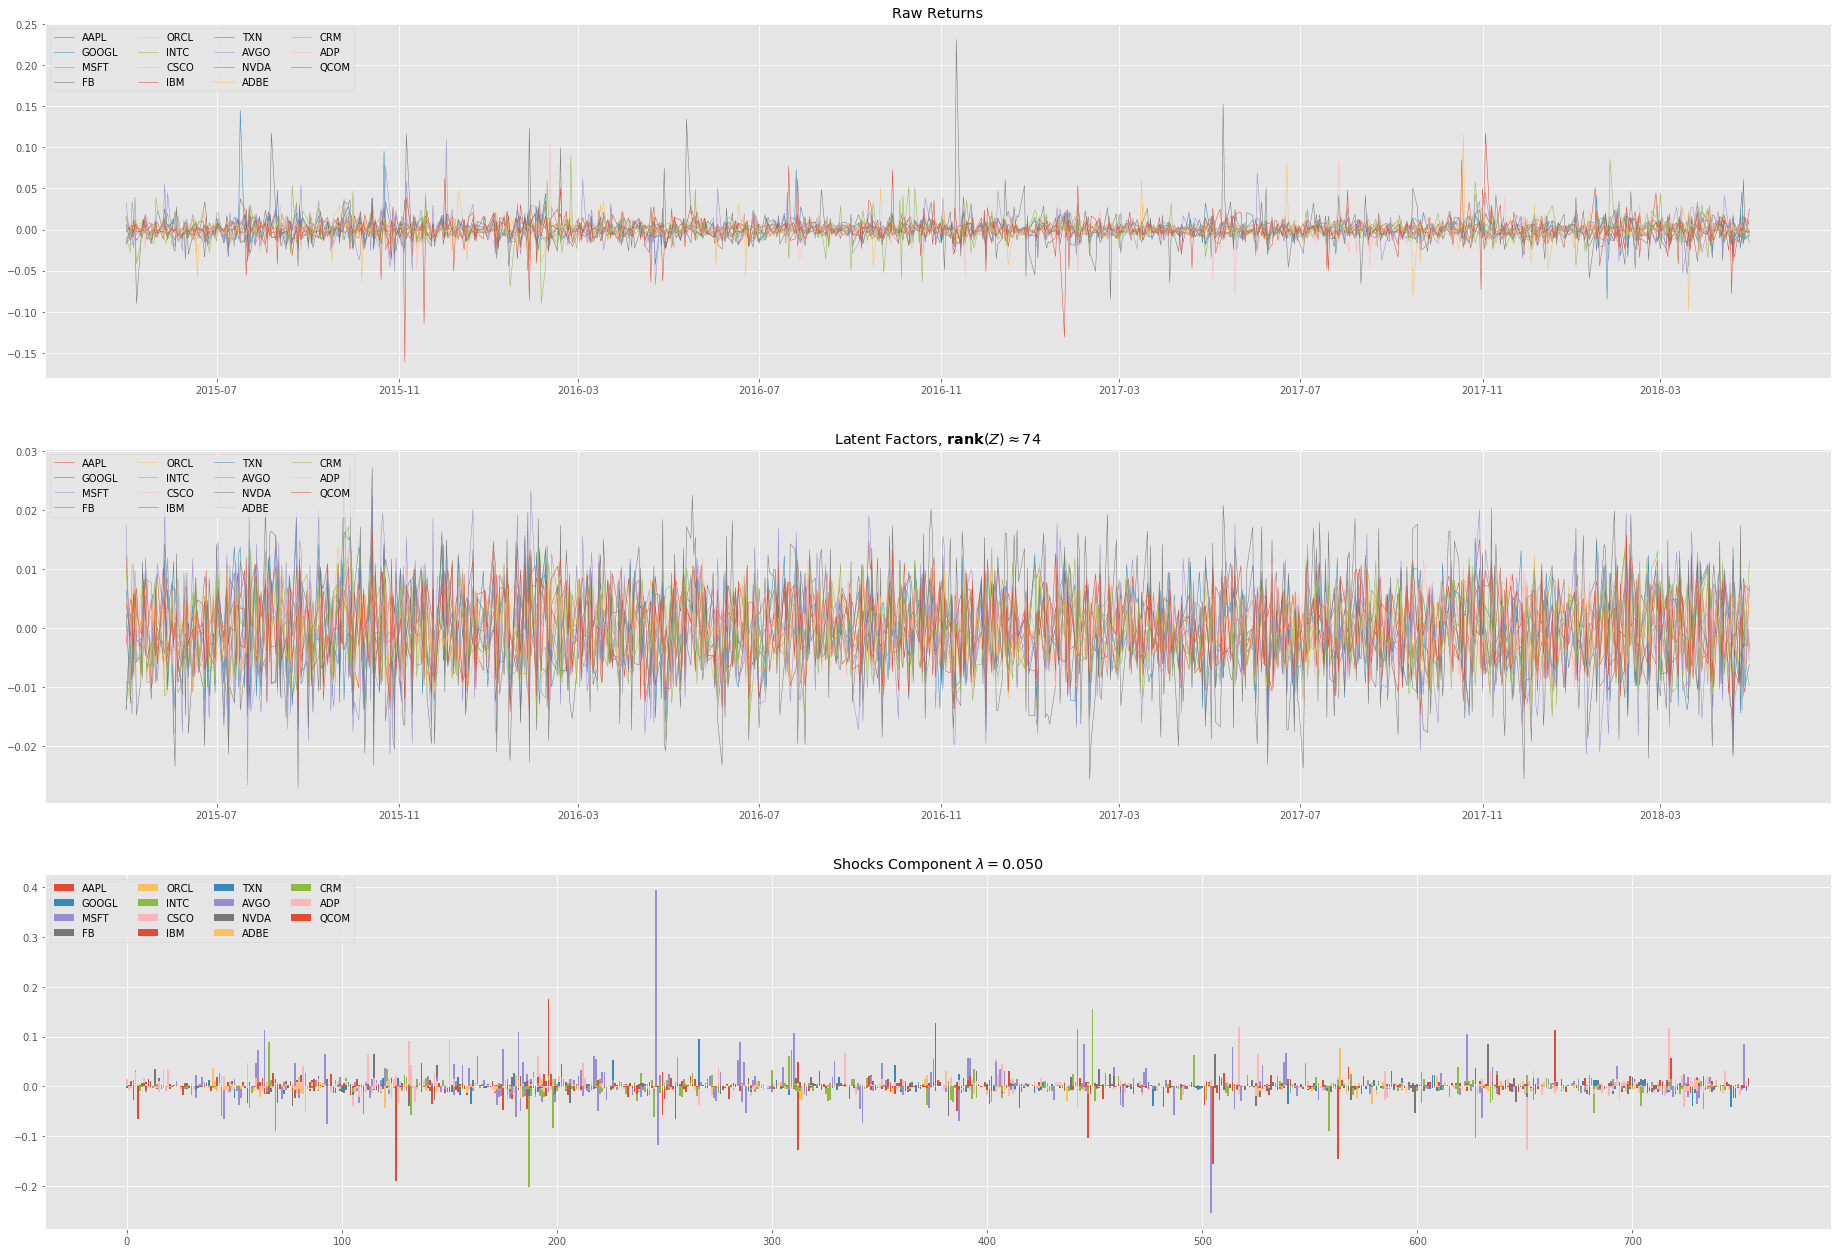




Set of charts for lambda = 0.010


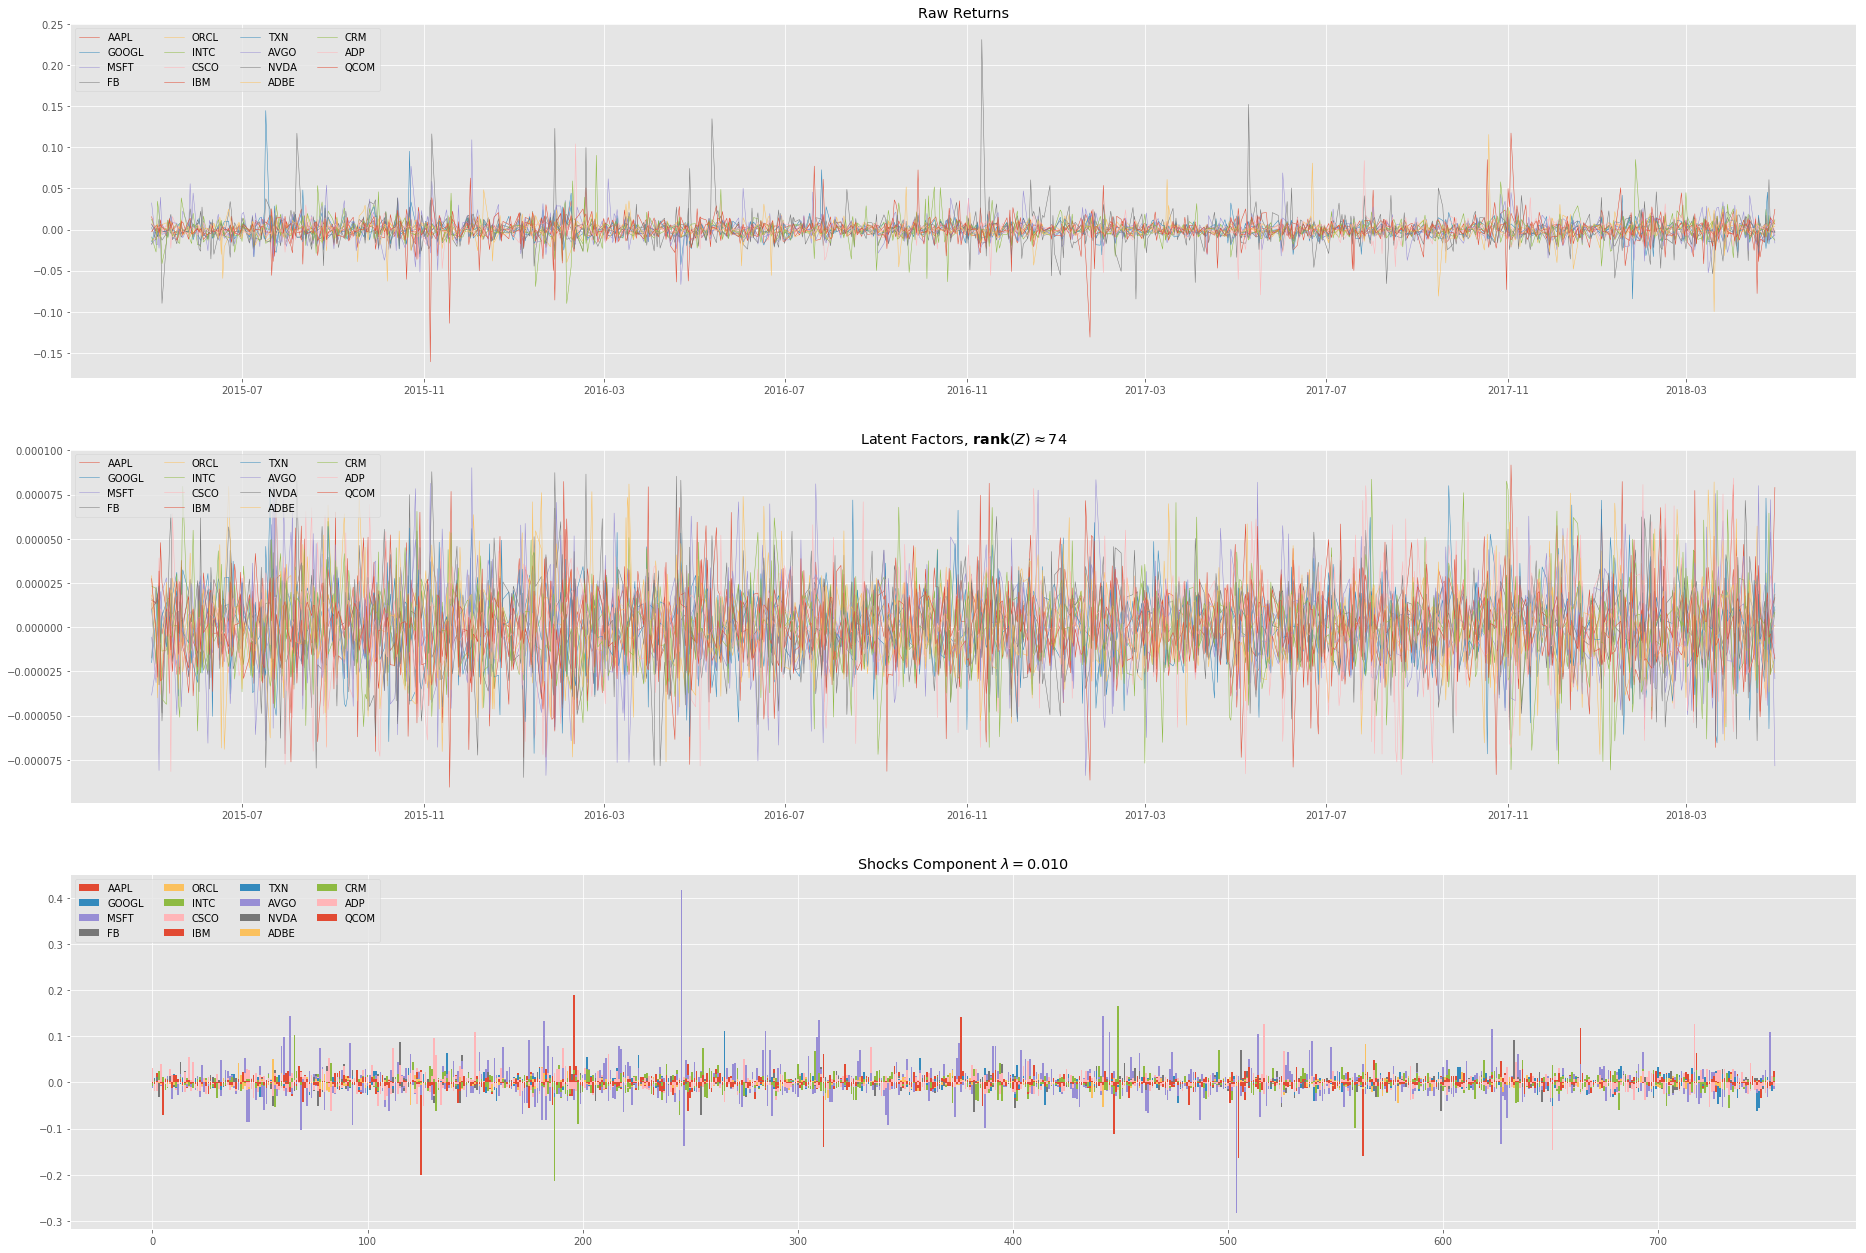




Set of charts for lambda = 0.005


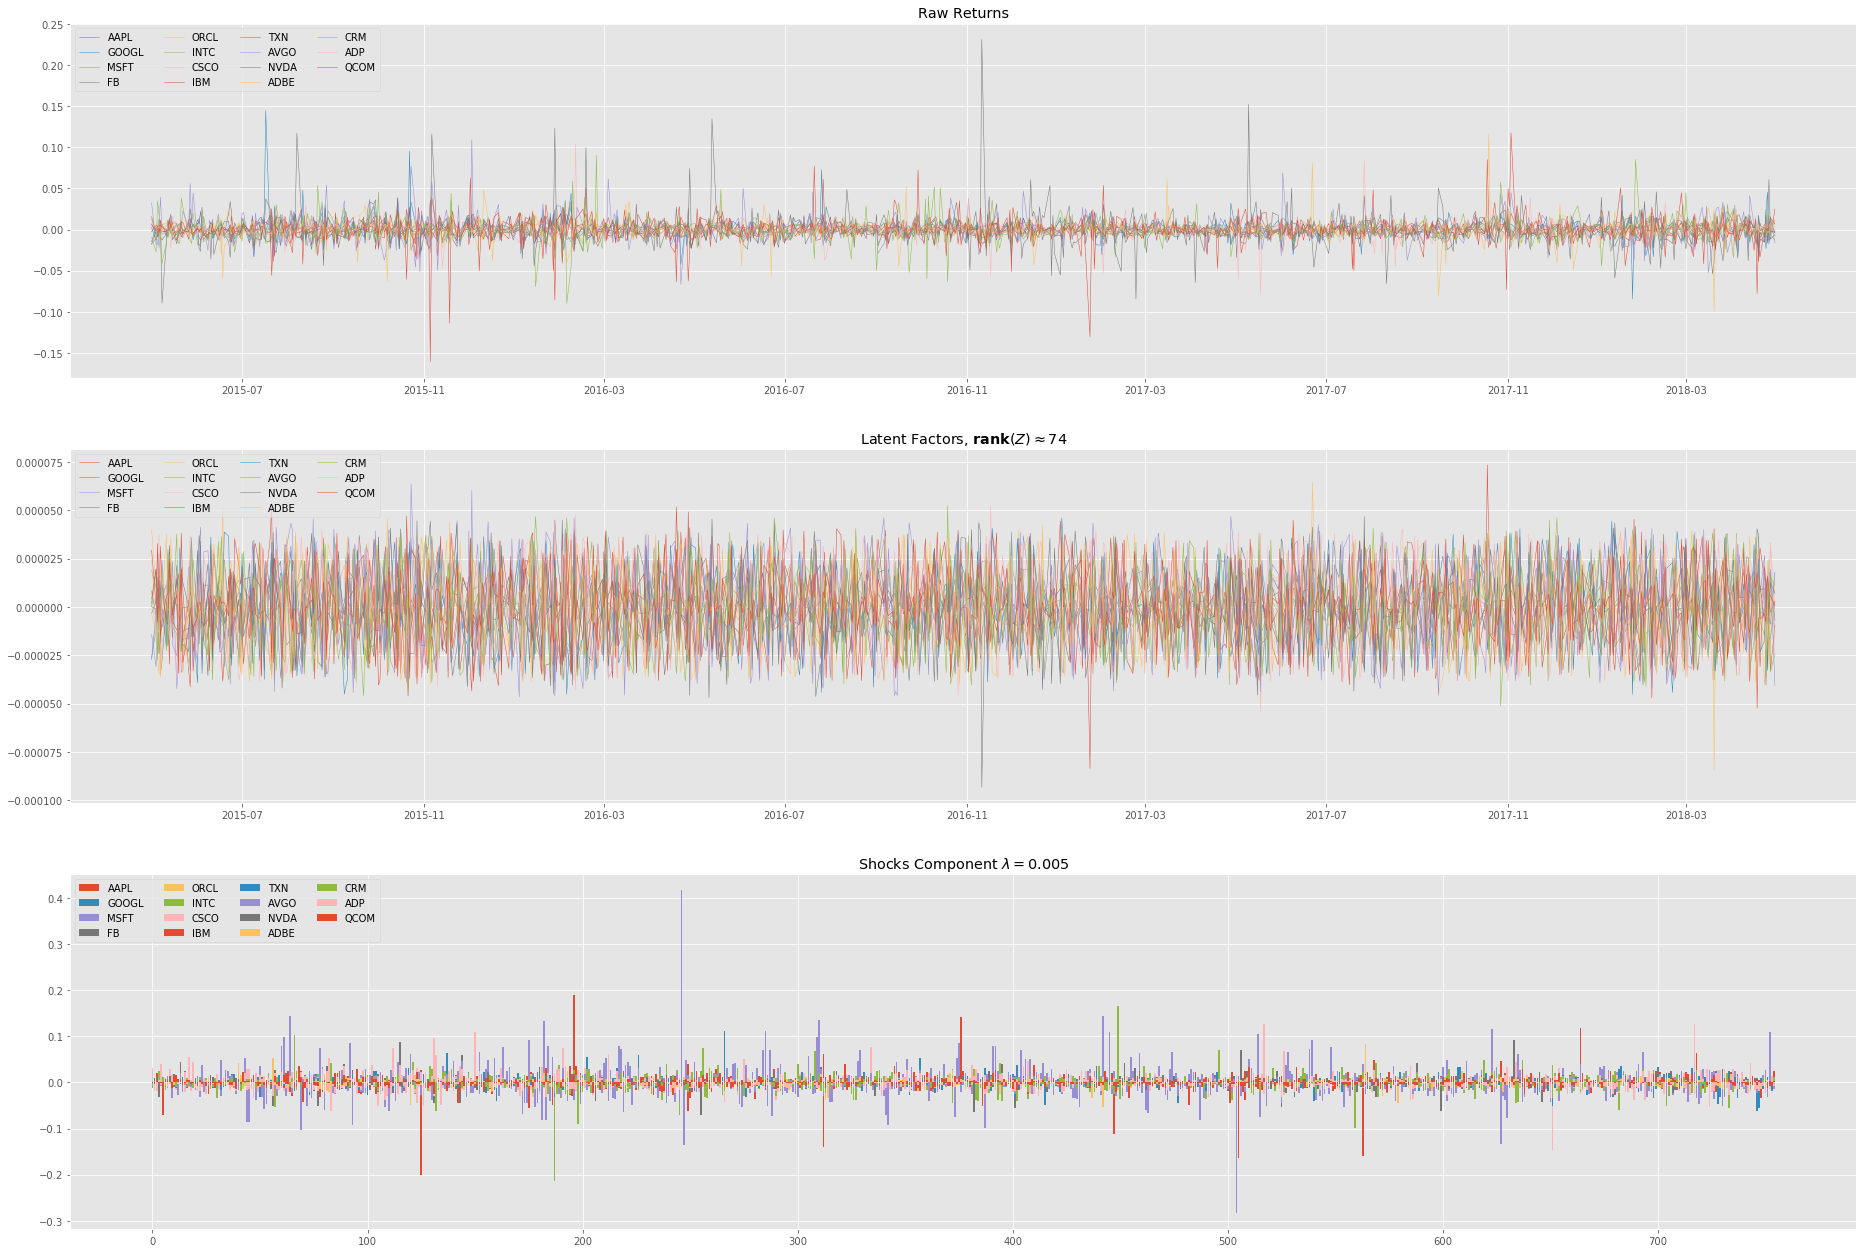

In [28]:
plt.style.use('ggplot')

for idx, lamb in enumerate(lamb_list):
    print('\n\n')
    print 'Set of charts for lambda = %.3f' % lamb
    
    plt.figure(figsize=(32, 30))

    # raw daily return series
    plt.subplot(len(lamb_list), 1, 1)
    for company in ticker_subset:
        plt.plot(style_resid_df[company], label=company, linewidth=.5)
    plt.title('Raw Returns')
    plt.legend(loc='upper left', ncol=4)


    # low rank returns
    plt.subplot(len(lamb_list), 1, 2)
    for company in ticker_subset:
        plt.plot(style_resid_df.index, Z_output[lamb][company], linewidth=.5,label=company)
    plt.title(r'Latent Factors, $\mathbf{rank}(Z) \approx %i$' % approxRank(Z_output[lamb]))
    plt.legend(loc='upper left', ncol=4)

    # sparse returns
    plt.subplot(len(lamb_list), 1, 3)
    S = np.array(S_output[lamb])
    grid = np.arange(S.shape[0])
    for col_num, company in enumerate(style_resid_df[ticker_subset]):
        plt.bar(grid, S[:, col_num], label=company)

    plt.title(r'Shocks Component $\lambda = %.3f$' % lamb)
    plt.legend(loc='upper left', ncol=4)
    plt.show()

**Comment:** It appears that the $rank(Z)$ is not reduced at all. This is in fact a known drawbacks of using Robust PCA for low-rank approximation, as $\|.\|_*$ is only an approximation for rank. However, judging from charts, $Z$ does capture a lot of co-variation of the selected tech stocks, as most of the time series in the middle plot oscillates within a tight band. This can be qualitatively classified as 'sysematic' variation within the sector.

Luckly the sparse component does appear to be quite sparse, even when $\lambda$ is low. I eventually choose $\lambda = 0.05$ to strike a balance between sparsity and having little variation.

#### 3.2.3 Further investigation on Robust PCA results - sparsity and earning surprises

Below I retrieved the sparse component of Nvidia from $S$ in attempt to look for patterns. Noticeably the spikes appear almost every 3 months. It seem to coinside with earning release date of Nvidia. I sorted the sparse return in decending order and observed that largest return appears repeatedly in May, August and November.

A positive spike could possibly indicates an earning suprise at annoucement, while negative spike a disappointment. I extracted the earning surprise data from Zacks.com and align it with the sparse return. Below I intended to investigate this hypothesis further. 

In [29]:
lamb = 0.05

latent_factor_ret = Z_output[lamb]
single_stock_lret = latent_factor_ret[stock_of_interest]
sparse_ret = S_output[lamb]
single_stock_sret = sparse_ret[stock_of_interest]

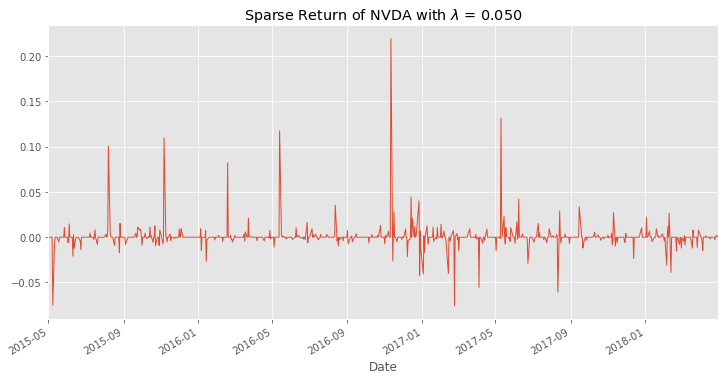

In [30]:
single_stock_sret[abs(single_stock_sret)< 1e-4] = 0
single_stock_sret.plot(lw=1,figsize=(12,6),
                       title='Sparse Return of %s with $\lambda$ = %.3f' 
                       % (stock_of_interest,lamb))

In [31]:
sorted_series = single_stock_sret[single_stock_sret!=0].sort_values(ascending=False)

pd.DataFrame(sorted_series.values,
             index = sorted_series.index,
             columns=['Sparse return']).head(10)

,Sparse return
Date,
2016-11-11,0.219271
2017-05-10,0.131476
2016-05-13,0.117596
2015-11-06,0.109768
2015-08-07,0.100710
2016-02-18,0.082412
2016-12-14,0.044313
2017-06-08,0.042127
2016-12-27,0.040110


In [32]:
earning_surprise = pd.read_excel(PATH+'nvda_earning_surprise.xlsx',index_col=0,parse_dates=True)

In [33]:
sparse_vs_surprise = single_stock_sret.to_frame('Sparse')
sparse_vs_surprise['Surprise'] = earning_surprise['Surprise']
sparse_vs_surprise.fillna(0,inplace=True)

In [34]:
surprised_date = sparse_vs_surprise.Surprise[sparse_vs_surprise.Surprise!=0].index
sparse_date = sparse_vs_surprise.Sparse[abs(sparse_vs_surprise.Sparse)>0.05].index

hit_ratio = float(len(list(set(surprised_date) & set(sparse_date))))/len(sparse_date)

print 'Hit ratio of earning surprise coinsides with sparse return whose absolute magnitude greater than 0.05: %.2f' % hit_ratio

Hit ratio of earning surprise coinsides with sparse return whose absolute magnitude greater than 0.05: 0.80


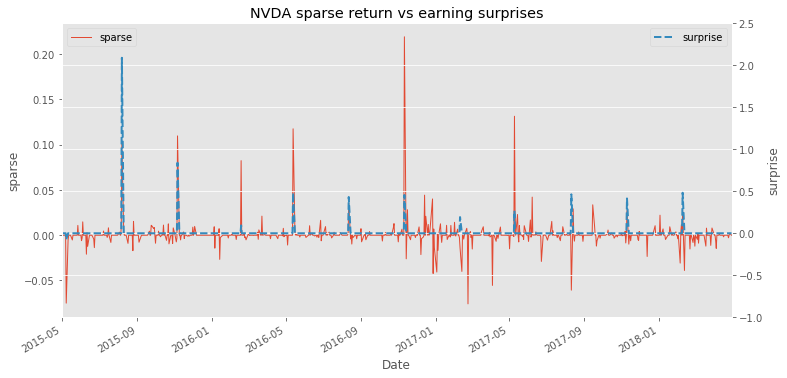

In [35]:
plt.figure(figsize=(12,6))
ax1 = sparse_vs_surprise.Sparse.plot(lw=1)
ax2 = sparse_vs_surprise.Surprise.plot(secondary_y=True,lw=2,style='--')

ax1.set_ylabel('sparse')
ax1.legend(['sparse'],loc=2)
ax2.set_ylabel('surprise')
ax2.legend(['surprise'],loc=1)
ax2.set_ylim(-1,2.5)
plt.title('NVDA sparse return vs earning surprises')

**Comment:** Almost all earning spikes coincide with large spare return spikes (whose absolute magnitude greater than 0.05), with a hit ratio of 80%. While not capturing all the shocks, it could serves as a reasonable timing approximation. Also noted is that the level and variation of spikes is not fully captured by the surprises. This could be because the earning surprise of one single firm is not comprehensive enough to capture the correlation with the sector or market earning surprises. Also, under different economic regime, the surprise factor might be suppressed or magnified. 

Nevertheless, it does not hurt to run a regression against its earning surprises. The earning surprises here is similar to a binary variable - 0 everywhere except for earning annoucement date. Below is the regression output. The result shows that the beta coefficient is significant, and R-square being 16.5%. This is a reasonable approximation for shocks, considering the variable contains almost only zero everywhere.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 20 Jun 2018   Prob (F-statistic):                nan
Time:                        23:59:13   Log-Likelihood:                 1913.8
No. Observations:                 755   AIC:                            -3824.
Df Residuals:                     753   BIC:                            -3814.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -1.182      0.2

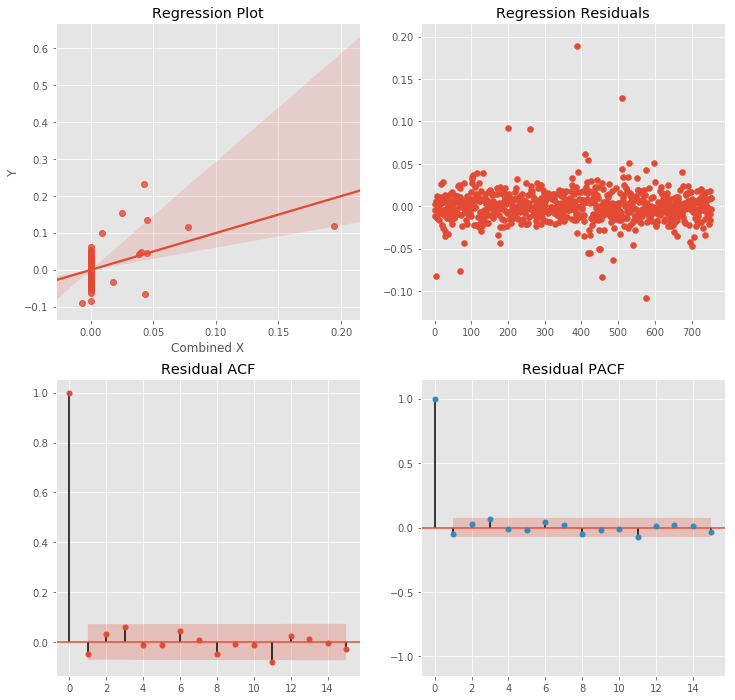

In [36]:
lin_reg(Y=single_style_ind_res.resid, X=sparse_vs_surprise['Surprise'], print_plots=True, print_summary=True)

## 4. Conclusion

I modeled the daily return of Nvidia as a combination of systematic return and idiosyncratic return. The systematic piece is carried out under a multi-factor framework. It consists of two stage of regressions: first stage is the standard CAPM, its residual is regressed against style factors and industry returns in the second stage. From the two stage framework, it is observed that *Market* together with *Value*, *Momentum* and *Industry* together can explain some systematic variation of the return (with R-square 21% and 17%, respectively in each regression). 

In an attempt to further investigate the systematic component, I performed the same two stage regression on all tech stocks, retrieved the residual and applied Robust PCA, with hope to find a low rank approximation of latent factors. However, due to limitations of Robust PCA, the low rank matrix cannot be retrieved successfully. 

Nevertheless, the other output from Robust PCA provided some insights about the sparse returns or shocks. Most of the dominant shocks coincided with the earning surprises. I therefore run another regression of Nvidia two-stage residuals against earning surprises. The result showed the earning surprises has some explanation power. It's not perfect of course, as spikes on earning annoucement are also correlated to peers earning and the overall market and economic dynamics.

In sum, to model the contemporaneous return on daily horizon, I would use a two-stage multifactor framework as discussed above and at earning day factoring in the surprise from earning release. 

## 5. Future Steps
1. All style factor data uses ETF as proxies. This may cause some collinearity and may lack in explanation power compared to classical long-short factors. If there are sources for clean raw factor data it would be helpful.
2. All regressions a single period. If given more time, I would modify the regressions (and subsequent PCAs) to perform on a rolling basis, as the betas are time varying. 
3. There are better but more complicated ways to perform low rank approximation. Robust PCA failed half of its purpose. However, a lot of statistical learning approaches are poor in interpretability. If I have more time I would explore more options here (maybe constructing different factors).
4. Construct more comprehensive earning surprise factors that incorporate sector/market dynamics and economic regimes.